In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mapel.elections as mapel
import scripts.experiments as experiments
import os
import numpy as np
from matplotlib import ticker

In [2]:
family = 'euclidean'
num_candidates = 35
num_voters = 80
heuristics = [
    'greedy_dp',
    'pairs',
    'basin_hopping',
    'basin_hopping_random',
]
exact_algorithm = 'gurobi'

results_dir = os.path.join('results', f'{num_candidates}x{num_voters}', family, 'one_step_metric')

In [7]:
results_dir

'results/35x80/euclidean/one_step_metric'

In [13]:
one_step_metrics = {}
for heuristic in heuristics:
    report = pd.read_csv(os.path.join(results_dir, heuristic, f'report.csv'))
    reference_report = pd.read_csv(os.path.join(
        results_dir,  heuristic, f'reference-report.csv'))
    
    print(heuristic)
    # print(report.head())
    # print(reference_report.head())
    
    merged = pd.merge(report, reference_report, on=('experiment_size', 'idx'), suffixes=('', '_reference'), how='inner')
    
    print('-' * 120)    
    
    
    num_experiments = len(merged['idx'].unique())
    merged['one_step_metric'] = merged['distance'] / merged['distance_reference']
    merged = merged[['experiment_size', 'idx', 'one_step_metric']]
    merged = merged.groupby('experiment_size').aggregate(['mean', 'std']).reset_index()
    merged['num_experiments'] = num_experiments
    one_step_metrics[heuristic] = merged[['experiment_size', 'num_experiments', 'one_step_metric']]

greedy_dp
------------------------------------------------------------------------------------------------------------------------
pairs
------------------------------------------------------------------------------------------------------------------------
basin_hopping
------------------------------------------------------------------------------------------------------------------------
basin_hopping_random
------------------------------------------------------------------------------------------------------------------------


In [16]:
def plot_one_step_metric(algorithm, one_step_metrics):
    metric = one_step_metrics[algorithm]['one_step_metric']['mean']
    std = one_step_metrics[algorithm]['one_step_metric']['std']
    experiment_size = one_step_metrics[algorithm]['experiment_size']
    tries = one_step_metrics[algorithm]['num_experiments'][0]
    fig, ax = plt.subplots(dpi=200)
    ax.set_xlabel('Number of starting elections from the reference')
    ax.set_ylabel('Percentage of summed distances to the reference')
    ax.bar(experiment_size, metric, yerr=std, capsize=2)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
    ax.set_ylim(0, 1)
    ax.set_title(f'Farthest elections for {algorithm}, tries={tries}')
    return fig, ax

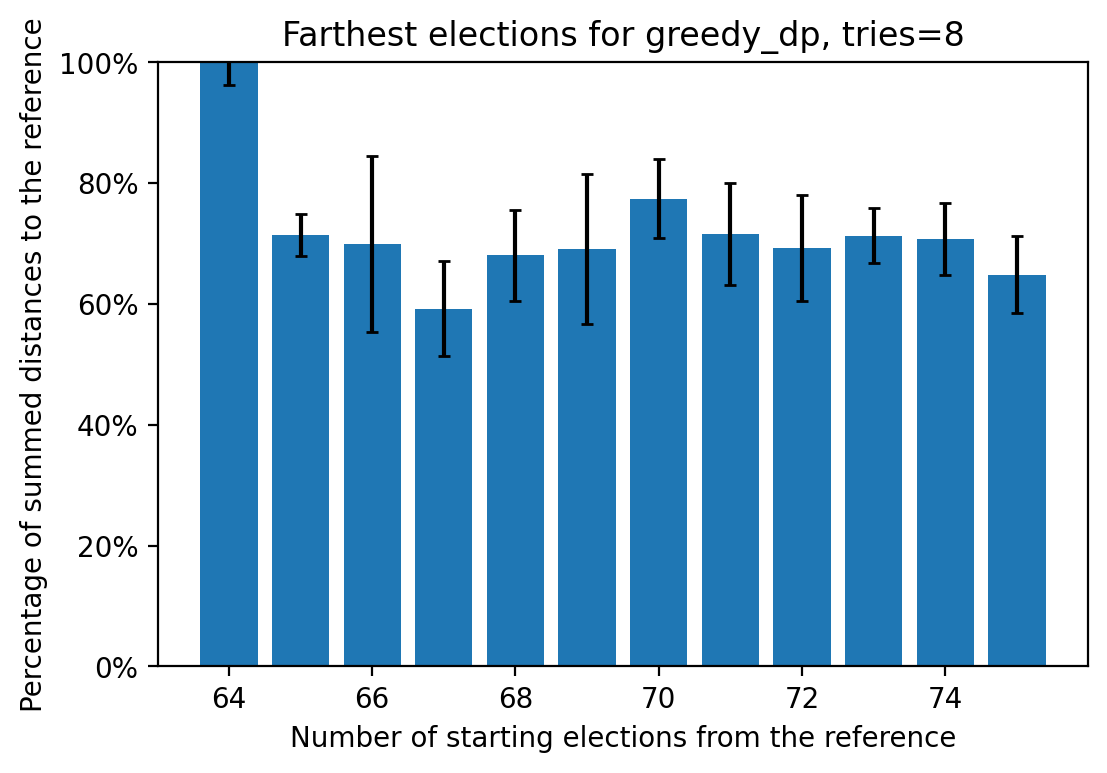

In [17]:
algorithm = 'greedy_dp'
fig, ax = plot_one_step_metric(algorithm, one_step_metrics)

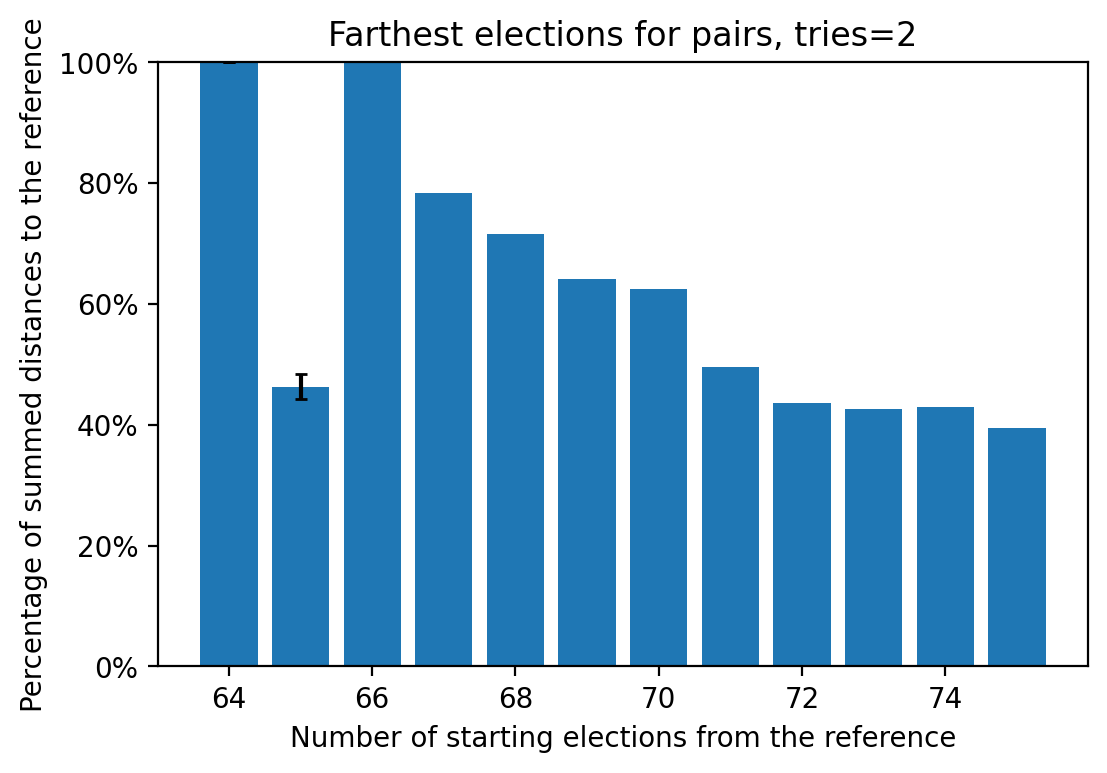

In [18]:
algorithm = 'pairs'
fig, ax = plot_one_step_metric(algorithm, one_step_metrics)

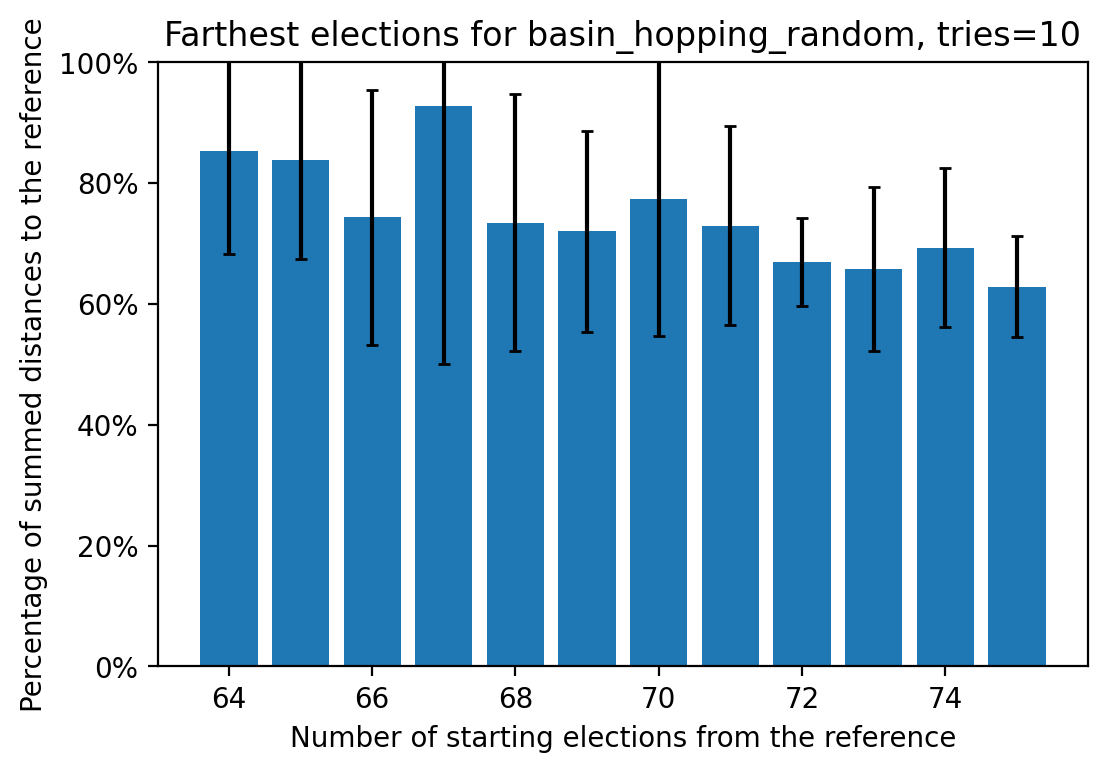

In [51]:
algorithm = 'basin_hopping_random'
fig, ax = plot_one_step_metric(algorithm, one_step_metrics)

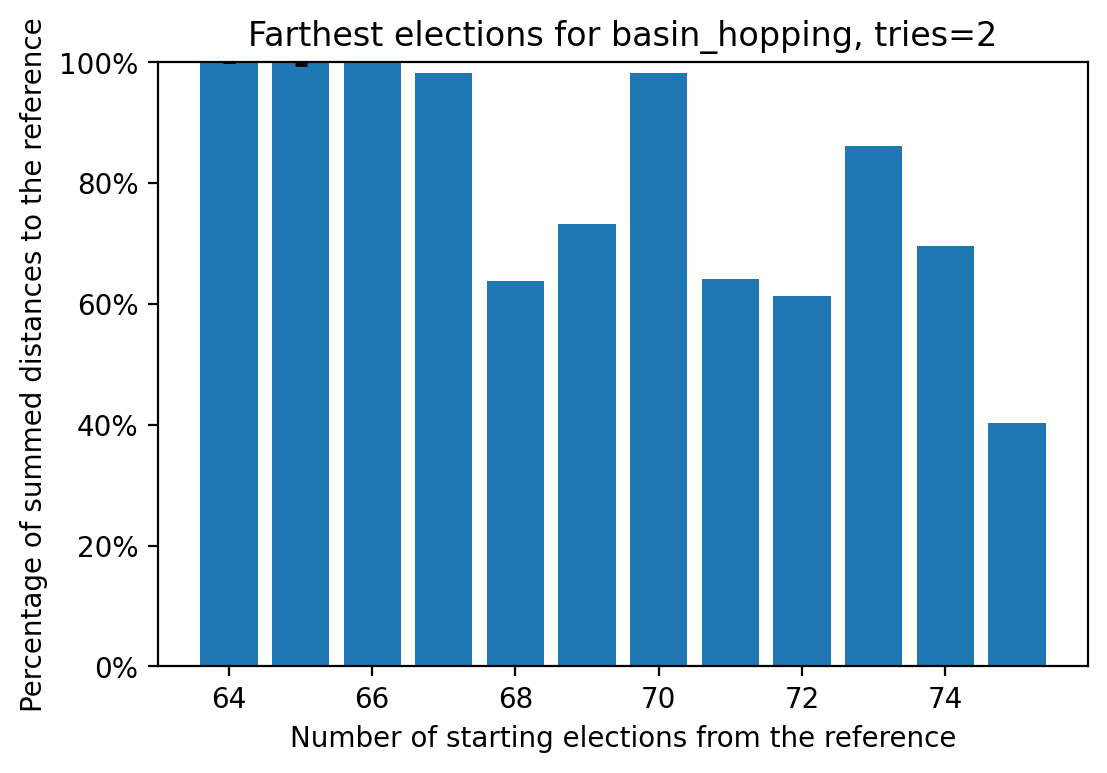

In [19]:
algorithm = 'basin_hopping'
fig, ax = plot_one_step_metric(algorithm, one_step_metrics)

In [31]:
stacked_metrics = pd.concat(one_step_metrics, keys=one_step_metrics.keys(), names=['id']).reset_index().drop('level_1', axis=1)
stacked_metrics['mean'] = stacked_metrics['one_step_metric']['mean']
stacked_metrics['std'] = stacked_metrics['one_step_metric']['std']

/var/folders/bf/p92d0jbn21q1hjbwx612yp480000gn/T/ipykernel_94368/2168387316.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  stacked_metrics = pd.concat(one_step_metrics, keys=one_step_metrics.keys(), names=['id']).reset_index().drop('level_1', axis=1)


In [42]:
import plotly.express as px
fig = px.bar(stacked_metrics, x="experiment_size", y="mean", color="id",
                  error_y="std", barmode='group')
fig.update_yaxes(tickformat=".0%")
fig.show()